In [1]:
import sys
sys.path.append(r'../')
from qdx.code_finder import CodeFinder
import os 
import jax
import time 
import json
import pickle
import numpy as np
import jax.numpy as jnp

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Example of [[7,1,3]] code discovery

#### This corresponds to Fig.10 in the paper

In [2]:
# With a single config variable we define our training
# Variable names should be quite explanatory. Otherwise check Appendix C
config = {
    "ENV_TYPE": "STANDARD", # Possibilities: "STANDARD", "MAX", "DELTA", "NOISE-AWARE"
    "N": 7,
    "K": 1,
    "D": 3,
    "MAX_STEPS": 20,
    "WHICH_GATES": ["cx", "h"],
    "GRAPH": "All-to-All",
    "SOFTNESS": 1,
    "P_I": 0.9,
    "LAMBDA": 10,
    "SEED": 42,
    "LR": 1e-3,
    "NUM_ENVS": 16,
    "NUM_STEPS": 20,
    "TOTAL_TIMESTEPS": 2e6,
    "UPDATE_EPOCHS": 3,
    "NUM_MINIBATCHES": 4,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.02,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.25,
    "ACTIVATION": "relu",
    "HIDDEN_DIM": 32,
    "ANNEAL_LR": True,
    "NUM_AGENTS": 4,
    "COMPUTE_METRICS": True,
}


finder = CodeFinder(config)
# Training should take around 20sec
params, metrics = finder.train()

==== Training started
==== Training finished, time elapsed: 22.62816 s


## Let's extract the returns and the circuit sizes to see the training trajectory

In [3]:
returns = metrics["returned_episode_returns"]
lengths = metrics["returned_episode_lengths"]

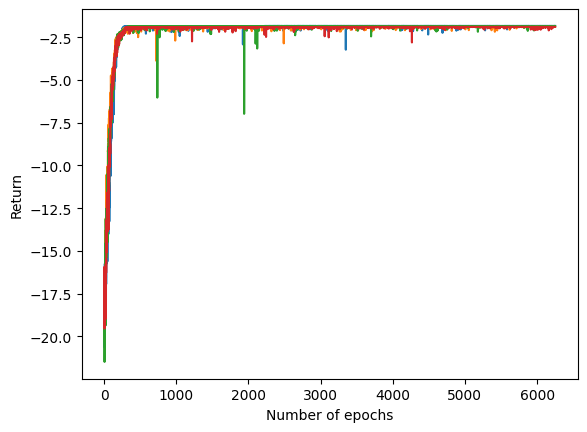

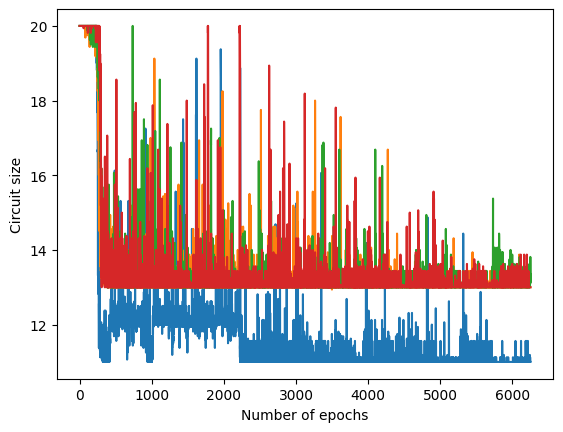

In [4]:
x = np.linspace(0, config["NUM_EPOCHS"], len(returns[0]))

# Each curve is a different agent
for i in range(config["NUM_AGENTS"]):
    plt.plot(x, returns[i])
plt.xlabel("Number of epochs")
plt.ylabel("Return")
plt.show() 

# Each curve is a different agent
for i in range(config["NUM_AGENTS"]):
    plt.plot(x, lengths[i])
plt.xlabel("Number of epochs")
plt.ylabel("Circuit size")
plt.show() 

## We can evaluate our agents to extract the circuits

In [5]:
data = finder.evaluate()

In [6]:
# We print the results from the first agent, for example
data[0]

{'n': 7,
 'k': 1,
 'd': 3,
 'gates': ['.h(1)',
  '.cx(1, 0)',
  '.cx(1, 6)',
  '.cx(0, 4)',
  '.h(6)',
  '.cx(6, 2)',
  '.cx(6, 4)',
  '.cx(1, 3)',
  '.h(0)',
  '.cx(6, 0)',
  '.cx(0, 5)']}

## Finally, let's visualize the discovered circuits

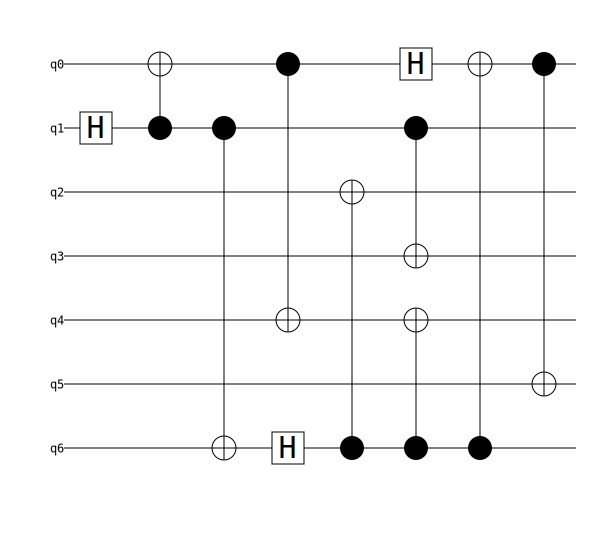

In [7]:
from IPython.display import SVG, display
import stim

gates = data[0]['gates']
actions = []

for g in gates:
    gate_name = g.split("(")[0].split(".")[1]
    qubit_ids = g.split("(")[1].split(")")[0]
    instruction = '.append("%s", [%s])' % (gate_name, qubit_ids)
        
    actions.append(instruction)
    

circ = stim.Circuit()
for action in actions:
    eval('circ%s' % action)
    
circ.diagram('timeline-svg')

# Example of [[6,1]] code discovery with the noise-aware meta agent

We choose d=4 since we know it will not succeed. We therefore force it to correct the most dangerous errors only

In [8]:
config = {
    "ENV_TYPE": "NOISE-AWARE", # Possibilities: "STANDARD", "MAX", "DELTA", "NOISE-AWARE"
    "N": 6,
    "K": 1,
    "D": 4,
    "MAX_STEPS": 30,
    "WHICH_GATES": ["cx", "h", "s"],
    "GRAPH": "All-to-All",
    "SOFTNESS": 1,
    "P_I": 0.9,
    "LAMBDA": 1,
    "SEED": 42,
    "LR": 5e-4,
    "NUM_ENVS": 64,
    "NUM_STEPS": 8,
    "TOTAL_TIMESTEPS": 4e6,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": 8,
    "GAMMA": .99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.1,
    "ENT_COEF": 0.01,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.05,
    "ACTIVATION": "relu",
    "HIDDEN_DIM": 200,
    "ANNEAL_LR": True,
    "NUM_AGENTS": 4,
    "COMPUTE_METRICS": True,
}


finder = CodeFinder(config)
# Training is now more costly. It should train in approx 60 sec.
params, metrics = finder.train()

E0526 18:03:07.853063   15501 hlo_lexer.cc:443] Failed to parse int literal: 772835708157529333592


==== Training started


==== Training finished, time elapsed: 54.00191 s


## Let's extract the returns and the circuit sizes to follow the training trajectory

In [10]:
returns = metrics["returned_episode_returns"]
lengths = metrics["returned_episode_lengths"]

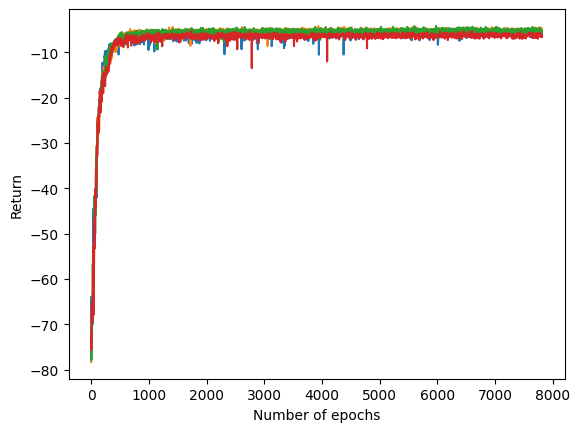

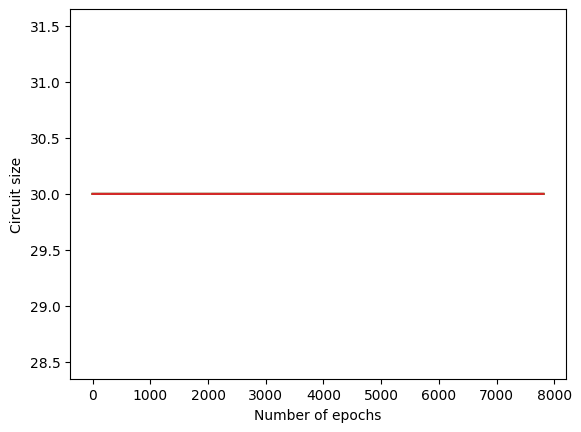

In [11]:
x = np.linspace(0, config["NUM_EPOCHS"], len(returns[0]))

# Each curve is a different agent
for i in range(config["NUM_AGENTS"]):
    plt.plot(x, returns[i])
plt.xlabel("Number of epochs")
plt.ylabel("Return")
plt.show() 

# Each curve is a different agent
for i in range(config["NUM_AGENTS"]):
    plt.plot(x, lengths[i])
plt.xlabel("Number of epochs")
plt.ylabel("Circuit size")
plt.show() 

The circuit size now does not decrease! This is due to the fact that the meta-agent cannot correct all the errors that we asked (by design) and instead corrects the most dangerous ones

## We can evaluate our agents to extract the circuits

In [12]:
# Evaluation is now more costly because each agent is evaluated at 16 different values of cZ
# TODO: Accelerate evaluation with vmap
data = finder.evaluate()

In [13]:
# Technically, the effective distance d_eff should be an integer. 
# Here it should be read as the smallest undetected effective weight
data[0]

{'n': 6,
 'k': 1,
 'cZ': 0.5,
 'd_eff': 2.0,
 'gates': ['.h(3)',
  '.cx(3, 2)',
  '.cx(0, 2)',
  '.h(0)',
  '.cx(0, 5)',
  '.cx(0, 2)',
  '.h(1)',
  '.cx(1, 0)',
  '.cx(3, 0)',
  '.cx(0, 5)',
  '.cx(2, 4)',
  '.cx(3, 2)',
  '.h(3)',
  '.cx(3, 2)',
  '.cx(3, 0)',
  '.cx(1, 0)',
  '.s(5)',
  '.s(4)',
  '.h(4)',
  '.s(3)',
  '.s(2)',
  '.s(4)',
  '.s(4)',
  '.s(4)',
  '.s(4)',
  '.s(4)',
  '.s(4)',
  '.s(4)',
  '.s(4)',
  '.s(4)']}

## Finally, let's visualize the discovered circuits

There might be a bunch of S gates applied at the very end. These can be ignored!

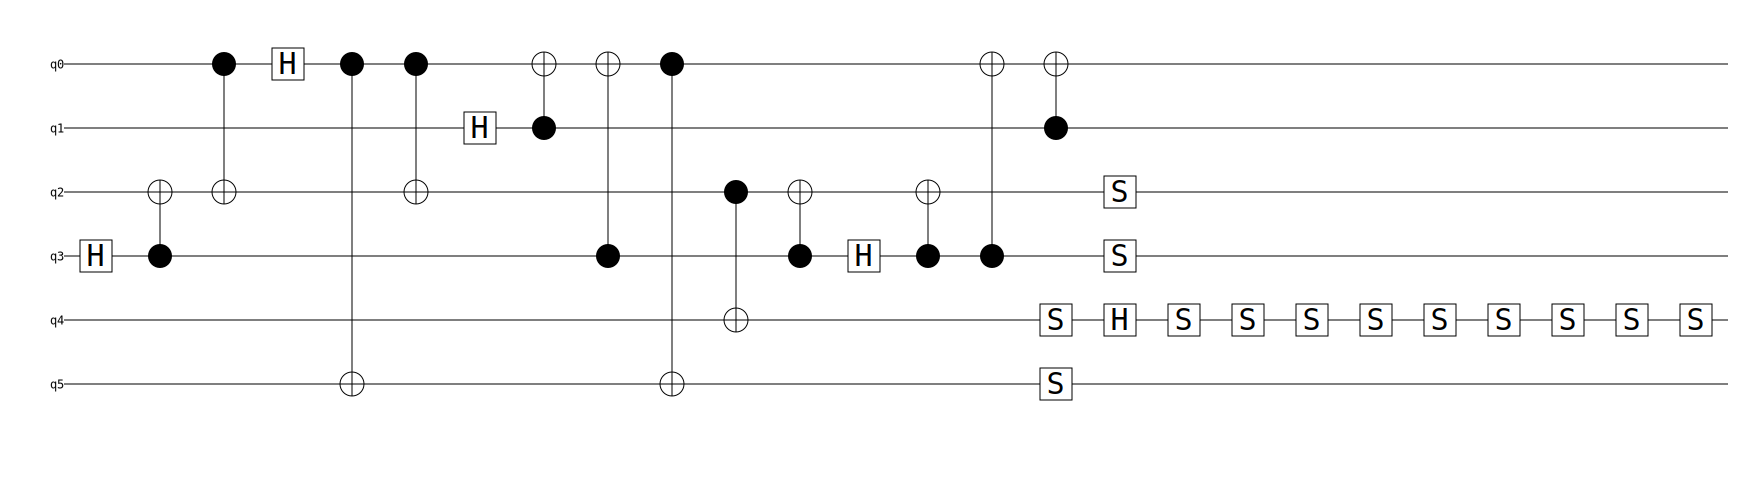

In [14]:
from IPython.display import SVG, display
import stim

gates = data[0]['gates']
actions = []

for g in gates:
    gate_name = g.split("(")[0].split(".")[1]
    qubit_ids = g.split("(")[1].split(")")[0]
    instruction = '.append("%s", [%s])' % (gate_name, qubit_ids)
        
    actions.append(instruction)
    

circ = stim.Circuit()
for action in actions:
    eval('circ%s' % action)
    
circ.diagram('timeline-svg')